# PTJPL for point forcing datasets
***************************************************************
<left> The below code is from [Fisher et al., 2008](http://josh.yosh.org/publications/Fisher%20et%20al%202008%20-%20Global%20estimates%20of%20the%20land-atmosphere%20water%20flux.pdf)
<left> Adjustments are made for application at daily timesteps
<left> This version of code was authored by: AJ Purdy
<left> Major Contributions for this code are from Gregory Halverson & Grayson Badgley
<left> Contact:  ajpurdy@uci.edu     
***************************************************************

    Input variables within DATAFRAME:     
        air_temperature: air temperature near the surface (C)
        air_temperature_mean: daily average air temperature near the surface (K)        
        RH_day_min: minimum daily relative humidity(%) 
           replacement if not avail --> daily minimum vapor pressure (Pa)
        ndvi_mean: average Normalized Difference Vegetation Index for day        
        optimum_temperature: phenologically optimum temperature (K)
        fAPARmax: maximum fraction of photosynthetically active radiation (unitless)   
        net_radiation: instantaneous net radiation in (W/m2) 
        daily_radiation: daily net radiation in (W/m2)
        
    Returned:
        A dataset is returned from this script containing the following variables:
        evapotranspiration: total evapotranspiration (W/m2)
        interception_evaporation: intercepted evaporation (W/m2) 
        soil_evaporation: evaporation from soil (W/m2)
        canopy_transpiration: transpiration from canopy (W/m2)                       
        potential_evapotranspiration: potential evapotranspiration (W/m2)
        
***************************************************************


In [1]:
import datetime
import glob
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import numpy as np
from numpy.ma import exp, log
import os
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
# FILE PATHWAYS
data_path = r'C:\GitWork\H8AHI_ET\Reference\data'

In [3]:
# ----------------------- MODEL IS IN THE LIBRARY REFERENCED HERE ---------------------- 
from ptjpl_lib import *
# ----------------------------- NOTEBOOK SPECIFIC COMMANDS ----------------------------- 
# % matplotlib inline
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:90% !important; }</style>"))

datMMS = pd.read_csv(data_path + '/US-MMS_fc.csv')
df_MMS = datMMS.set_index('Time')

In [4]:
type(df_MMS)

pandas.core.frame.DataFrame

In [5]:
df_MMS

,SM_COSMOS,TA,NETRAD,G,LE,H,RH,TA_dl,NETRAD_dl,G_dl,LE_dl,H_dl,RH_dl,TA_day_mean,TA_day_max,TA_day_min,RH_day,RH_day_min,NETRAD_day,G_day,LE_day,H_day,SM1,P_mm,TS_day_MAX,NDVI,LE_FC
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.757125,-2.193,49.103,-8.402,1.365,14.468,0.83362,-1.935286,72.137286,-8.273571,7.113143,25.758857,0.812231,-1.378458,1.300,-4.840,0.837897,0.77118,15.763083,-8.485783,3.040792,8.601875,0.414999,0.000000,3.509,0.431233,1.993683
2013-01-02,0.632708,-7.895,195.077,-17.460,2.120,56.469,0.72878,-5.340286,210.096857,-16.022429,22.795286,103.126000,0.592960,-6.390042,-3.110,-9.476,0.661049,0.46072,21.789375,-14.158542,9.480042,27.296750,-3.769251,0.000000,3.267,0.428206,3.096417
2013-01-03,0.582958,-5.470,231.166,-17.855,3.423,52.692,0.66180,-2.658286,212.848286,-15.794429,8.752714,72.140286,0.672613,-4.093125,0.080,-7.605,0.664053,0.50948,30.559167,-15.447500,2.257792,5.944792,0.412737,0.000000,2.720,0.425179,4.999544
2013-01-04,0.613292,-3.203,228.543,-10.827,-12.608,144.740,0.76031,-1.971286,249.912857,-10.264429,13.752857,140.643429,0.652186,-2.224292,-0.275,-3.811,0.717988,0.56178,37.076125,-10.070625,3.183250,31.707125,0.411096,0.000000,2.783,0.422152,-18.414915
2013-01-05,0.596625,-2.135,192.995,-12.572,-0.403,30.604,0.82717,1.058571,185.083000,-11.376714,11.516714,43.691429,0.657807,-0.573583,3.535,-3.488,0.767327,0.51977,19.035250,-10.687083,3.023333,-2.122167,0.410804,0.004167,2.822,0.419125,-0.588611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-14,0.439125,4.745,313.699,-13.054,23.786,136.493,0.39781,7.975714,316.371714,-2.561143,33.307143,175.165286,0.293123,4.755542,11.674,-0.643,0.412003,0.19509,43.927750,-11.839125,10.380583,26.104708,-99.990000,0.000000,6.585,0.396669,34.741209
2013-11-15,0.426583,6.332,73.031,-6.901,3.210,3.704,0.42460,8.314143,139.683286,-1.676429,12.389571,51.076857,0.402107,7.689000,11.159,5.029,0.440920,0.31852,8.279125,-6.224792,2.815750,-4.015750,-99.990000,0.000000,7.282,0.392112,4.688442
2013-11-16,0.524708,9.894,70.854,3.693,-1.460,NaN,0.96662,12.068429,143.395429,9.065286,21.266429,127.484400,0.876489,11.441750,15.449,7.817,0.906235,0.75011,39.342583,5.404875,3.974958,32.227857,-99.990000,0.054167,9.322,0.387556,-2.132438


In [6]:
df_model_MMS = ptjpl(df_MMS)

calculating surface wetness values [%]
calculating vapor pressure deficit [kPa]
calculating vegetation values
calculating plant optimum temperature
27.1351 C
calculating soil evaporation
calculating canopy transpiration
calculating interception evaporation
combining evapotranspiration
calculating daily evapotranspiration
calculating potential evapotranspiration


In [7]:
df_model_MMS

,SM_COSMOS,TA,NETRAD,G,LE,H,RH,TA_dl,NETRAD_dl,G_dl,LE_dl,H_dl,RH_dl,TA_day_mean,TA_day_max,TA_day_min,RH_day,RH_day_min,NETRAD_day,G_day,LE_day,H_day,SM1,P_mm,TS_day_MAX,NDVI,LE_FC,RH_roll,fAPAR,fIPAR,VPD_roll,soil_moisture_constraint,savi,VPD,evapotranspiration,potential_evapotranspiration,canopy_transpiration,interception_evaporation,soil_evaporation
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.757125,-2.193,49.103,-8.402,1.365,14.468,0.83362,-1.935286,72.137286,-8.273571,7.113143,25.758857,0.812231,-1.378458,1.300,-4.840,0.837897,0.77118,15.763083,-8.485783,3.040792,8.601875,0.414999,0.000000,3.509,0.431233,1.993683,0.77118,0.396478,0.381233,0.228820,0.000000,0.326055,0.228820,1.948055,18.405186,1.948055,0.000000,0.000000
2013-01-02,0.632708,-7.895,195.077,-17.460,2.120,56.469,0.72878,-5.340286,210.096857,-16.022429,22.795286,103.126000,0.592960,-6.390042,-3.110,-9.476,0.661049,0.46072,21.789375,-14.158542,9.480042,27.296750,-3.769251,0.000000,3.267,0.428206,3.096417,0.46072,0.394621,0.378206,0.539280,0.000000,0.324693,0.539280,0.881066,56.437881,0.881066,0.000000,0.000000
2013-01-03,0.582958,-5.470,231.166,-17.855,3.423,52.692,0.66180,-2.658286,212.848286,-15.794429,8.752714,72.140286,0.672613,-4.093125,0.080,-7.605,0.664053,0.50948,30.559167,-15.447500,2.257792,5.944792,0.412737,0.000000,2.720,0.425179,4.999544,0.50948,0.392764,0.375179,0.490520,0.000000,0.323331,0.490520,6.233032,74.929423,6.233032,0.000000,0.000000
2013-01-04,0.613292,-3.203,228.543,-10.827,-12.608,144.740,0.76031,-1.971286,249.912857,-10.264429,13.752857,140.643429,0.652186,-2.224292,-0.275,-3.811,0.717988,0.56178,37.076125,-10.070625,3.183250,31.707125,0.411096,0.000000,2.783,0.422152,-18.414915,0.56178,0.390907,0.372152,0.438220,0.000000,0.321968,0.438220,7.839245,81.761223,7.839245,0.000000,0.000000
2013-01-05,0.596625,-2.135,192.995,-12.572,-0.403,30.604,0.82717,1.058571,185.083000,-11.376714,11.516714,43.691429,0.657807,-0.573583,3.535,-3.488,0.767327,0.51977,19.035250,-10.687083,3.023333,-2.122167,0.410804,0.004167,2.822,0.419125,-0.588611,0.51977,0.389050,0.369125,0.480230,0.000000,0.320606,0.480230,7.764099,72.094948,7.764099,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-11-14,0.439125,4.745,313.699,-13.054,23.786,136.493,0.39781,7.975714,316.371714,-2.561143,33.307143,175.165286,0.293123,4.755542,11.674,-0.643,0.412003,0.19509,43.927750,-11.839125,10.380583,26.104708,-99.990000,0.000000,6.585,0.396669,34.741209,0.19509,0.375275,0.346669,0.804910,0.582547,0.310501,0.804910,64.130053,149.053599,21.109306,0.109321,42.911425
2013-11-15,0.426583,6.332,73.031,-6.901,3.210,3.704,0.42460,8.314143,139.683286,-1.676429,12.389571,51.076857,0.402107,7.689000,11.159,5.029,0.440920,0.31852,8.279125,-6.224792,2.815750,-4.015750,-99.990000,0.000000,7.282,0.392112,4.688442,0.31852,0.372480,0.342112,0.722679,0.572669,0.308451,0.722679,16.580283,36.379570,5.918405,0.187631,10.474248
2013-11-16,0.524708,9.894,70.854,3.693,-1.460,NaN,0.96662,12.068429,143.395429,9.065286,21.266429,127.484400,0.876489,11.441750,15.449,7.817,0.906235,0.75011,39.342583,5.404875,3.974958,32.227857,-99.990000,0.054167,9.322,0.387556,-2.132438,0.75011,0.369685,0.337556,0.340834,0.594797,0.306400,0.340834,25.436014,38.934601,5.129841,6.111363,14.194810


Text(0, 0.5, '$Wm^{-2}$')

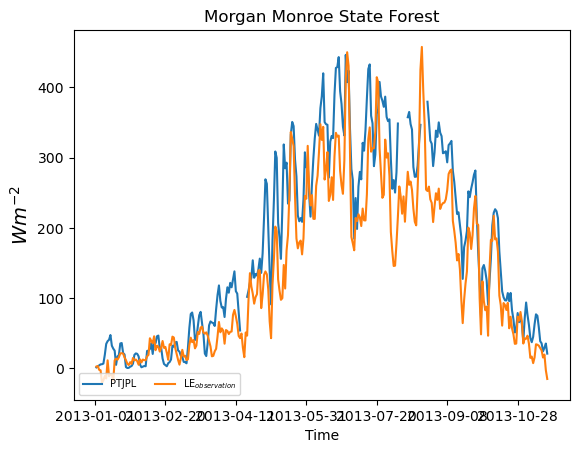

In [8]:
plt.figure()
df_model_MMS.evapotranspiration.rolling(4,2).mean().plot(label='PTJPL')
df_model_MMS.LE_FC.rolling(4,2).mean().plot(label='LE$_{observation}$')
plt.legend(ncol=2, loc = 3, fontsize = 7)
plt.title('Morgan Monroe State Forest')
plt.ylabel('$Wm^{-2}$', fontsize=14)

Text(0.5, 1.0, 'Morgan Monroe State Forest')

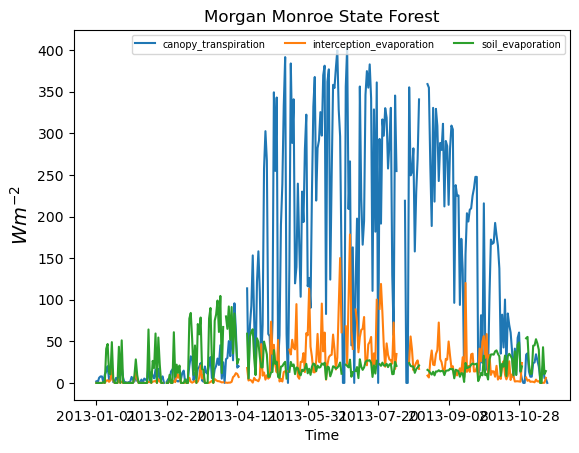

In [9]:
plt.figure()
df_model_MMS.canopy_transpiration.plot()
df_model_MMS.interception_evaporation.plot()
df_model_MMS.soil_evaporation.plot()
plt.legend(ncol=3, fontsize=7)
plt.ylabel('$Wm^{-2}$', fontsize=14)
plt.title('Morgan Monroe State Forest')